https://github.com/raghav64/SemiSuper_GAN/blob/master/SSGAN.ipynb

In [ ]:

                ############ Imports ############

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import time


In [ ]:
                ############ Initializations ############

num_classes = 10
channels = 1
height = 64
width = 64
# MNIST was resized to 64 * 64 for discriminator and generator architecture fitting
latent = 100
epsilon = 1e-7
labeled_rate = 0.2 # For initial testing


In [ ]:
                ############ Importing MNIST data ############

def get_data():
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets("/tmp/data/", one_hot=True, reshape=[])
    return mnist

                ############ Normalizing data ############
# Scaling in range (-1,1) for generator tanh output
def scale(x):
    # normalize data
    x = (x - 0.5) / 0.5
    return x


Discriminator and Generator architecture should mirror each other

In [ ]:
              ############ Defining Discriminator ############

def discriminator(x, dropout_rate = 0., is_training = True, reuse = False):
    # input x -> n+1 classes

    with tf.variable_scope('Discriminator', reuse = reuse):

      # x = ?*64*64*1

      print('Discriminator architecture: ')
      #Layer 1
      conv1 = tf.layers.conv2d(x, 128, kernel_size = [4,4], strides = [2,2],
                              padding = 'same', activation = tf.nn.leaky_relu, name = 'conv1') # ?*32*32*128
      print(conv1.shape)
      #No batch-norm for input layer
      dropout1 = tf.nn.dropout(conv1, dropout_rate)

      #Layer2
      conv2 = tf.layers.conv2d(dropout1, 256, kernel_size = [4,4], strides = [2,2],
                              padding = 'same', activation = tf.nn.leaky_relu, name = 'conv2') # ?*16*16*256
      batch2 = tf.layers.batch_normalization(conv2, training = is_training)
      dropout2 = tf.nn.dropout(batch2, dropout_rate)
      print(conv2.shape)

      #Layer3
      conv3 = tf.layers.conv2d(dropout2, 512, kernel_size = [4,4], strides = [4,4],
                              padding = 'same', activation = tf.nn.leaky_relu, name = 'conv3') # ?*4*4*512
      batch3 = tf.layers.batch_normalization(conv3, training = is_training)
      dropout3 = tf.nn.dropout(batch3, dropout_rate)
      print(conv3.shape)

      # Layer 4
      conv4 = tf.layers.conv2d(dropout3, 1024, kernel_size=[3,3], strides=[1,1],
                               padding='valid',activation = tf.nn.leaky_relu, name='conv4') # ?*2*2*1024
      # No batch-norm as this layer's op will be used in feature matching loss
      # No dropout as feature matching needs to be definite on logits
      print(conv4.shape)

      # Layer 5
      # Note: Applying Global average pooling

      flatten = tf.reduce_mean(conv4, axis = [1,2])
      logits_D = tf.layers.dense(flatten, (1 + num_classes))
      out_D = tf.nn.softmax(logits_D)

    return flatten,logits_D,out_D



In [ ]:
                ############ Defining Generator ############

def generator(z, dropout_rate = 0., is_training = True, reuse = False):
    # input latent z -> image x

    with tf.variable_scope('Generator', reuse = reuse):
      print('\n Generator architecture: ')

      #Layer 1
      deconv1 = tf.layers.conv2d_transpose(z, 512, kernel_size = [4,4],
                                         strides = [1,1], padding = 'valid',
                                        activation = tf.nn.relu, name = 'deconv1') # ?*4*4*512
      batch1 = tf.layers.batch_normalization(deconv1, training = is_training)
      dropout1 = tf.nn.dropout(batch1, dropout_rate)
      print(deconv1.shape)

      #Layer 2
      deconv2 = tf.layers.conv2d_transpose(dropout1, 256, kernel_size = [4,4],
                                         strides = [4,4], padding = 'same',
                                        activation = tf.nn.relu, name = 'deconv2')# ?*16*16*256
      batch2 = tf.layers.batch_normalization(deconv2, training = is_training)
      dropout2 = tf.nn.dropout(batch2, dropout_rate)
      print(deconv2.shape)

      #Layer 3
      deconv3 = tf.layers.conv2d_transpose(dropout2, 128, kernel_size = [4,4],
                                         strides = [2,2], padding = 'same',
                                        activation = tf.nn.relu, name = 'deconv3')# ?*32*32*256
      batch3 = tf.layers.batch_normalization(deconv3, training = is_training)
      dropout3 = tf.nn.dropout(batch3, dropout_rate)
      print(deconv3.shape)

      #Output layer
      deconv4 = tf.layers.conv2d_transpose(dropout3, 1, kernel_size = [4,4],
                                        strides = [2,2], padding = 'same',
                                        activation = None, name = 'deconv4')# ?*64*64*1
      out = tf.nn.tanh(deconv4)
      print(deconv4.shape)

    return out


In [ ]:
                ############ Building model ############

def build_GAN(x_real, z, dropout_rate, is_training):

    fake_images = generator(z, dropout_rate, is_training)

    D_real_features, D_real_logits, D_real_prob = discriminator(x_real, dropout_rate,
                                                              is_training)

    D_fake_features, D_fake_logits, D_fake_prob = discriminator(fake_images, dropout_rate,
                                                                is_training, reuse = True)
    #Setting reuse=True this time for using variables trained in real batch training

    return D_real_features, D_real_logits, D_real_prob, D_fake_features, D_fake_logits, D_fake_prob, fake_images


In [ ]:
                ############ Preparing Mask ############

# Preparing a binary label_mask to be multiplied with real labels
def get_labeled_mask(labeled_rate, batch_size):
    labeled_mask = np.zeros([batch_size], dtype = np.float32)
    labeled_count = np.int(batch_size * labeled_rate)
    labeled_mask[range(labeled_count)] = 1.0
    np.random.shuffle(labeled_mask)
    return labeled_mask



In [ ]:
               ############ Preparing Extended label ############

def prepare_extended_label(label):
    # add extra label for fake data
    extended_label = tf.concat([tf.zeros([tf.shape(label)[0], 1]), label], axis = 1)

    return extended_label

In [ ]:
            ############ Defining losses ############

# The total loss inculcates  D_L_Unsupervised + D_L_Supervised + G_feature_matching loss + G_R/F loss

def loss_accuracy(D_real_features, D_real_logit, D_real_prob, D_fake_features,
                  D_fake_logit, D_fake_prob, extended_label, labeled_mask):

                    ### Discriminator loss ###

    # Supervised loss -> which class the real data belongs to

    temp = tf.nn.softmax_cross_entropy_with_logits_v2(logits = D_real_logit,
                                                  labels = extended_label)
    # Don't confuse labeled_rate with labeled_mask
    # Labeled_mask and temp are of same size = batch_size where temp is softmax
    # cross_entropy calculated over whole batch

    D_L_Supervised = tf.reduce_sum(tf.multiply(temp,labeled_mask)) / tf.reduce_sum(labeled_mask)

    # Multiplying temp with labeled_mask gives supervised loss on labeled_mask
    # data only, calculating mean by dividing by no of labeled samples

    # Unsupervised loss -> R/F

    D_L_RealUnsupervised = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits = D_real_logit[:, 0], labels = tf.zeros_like(D_real_logit[:, 0], dtype=tf.float32)))

    D_L_FakeUnsupervised = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits = D_fake_logit[:, 0], labels = tf.ones_like(D_fake_logit[:, 0], dtype=tf.float32)))

    D_L = D_L_Supervised + D_L_RealUnsupervised + D_L_FakeUnsupervised


                    ### Generator loss ###

    # G_L_1 -> Fake data wanna be real

    G_L_1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits = D_fake_logit[:, 0],labels = tf.zeros_like(D_fake_logit[:, 0], dtype=tf.float32)))

    # G_L_2 -> Feature matching
    data_moments = tf.reduce_mean(D_real_features, axis = 0)
    sample_moments = tf.reduce_mean(D_fake_features, axis = 0)
    G_L_2 = tf.reduce_mean(tf.square(data_moments-sample_moments))


    G_L = G_L_1 + G_L_2

    prediction = tf.equal(tf.argmax(D_real_prob[:, 1:], 1),
                                  tf.argmax(extended_label[:, 1:], 1))
    accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))

    return D_L, G_L, accuracy


In [ ]:
            ############ Defining Optimizer ############

def optimizer(D_Loss, G_Loss, learning_rate, beta1):
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        all_vars = tf.trainable_variables()
        D_vars = [var for var in all_vars if var.name.startswith('Discriminator')]
        G_vars = [var for var in all_vars if var.name.startswith('Generator')]

        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1,
                                             name = 'd_optimiser').minimize(D_Loss, var_list=D_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1,
                                             name = 'g_optimiser').minimize(G_Loss, var_list=G_vars)

    return d_train_opt, g_train_opt

In [ ]:
            ############ Plotting Results ############

def show_result(test_images, num_epoch, show = True, save = False, path = 'result.png'):

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i in range(0, size_figure_grid):
      for j in range(0, size_figure_grid):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(size_figure_grid*size_figure_grid):
        i = k // size_figure_grid
        j = k % size_figure_grid
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k], (64, 64)), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):


    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()


In [ ]:
            ############ TRAINING ############

def train_GAN(batch_size, epochs):

    train_hist = {}
    train_hist['D_losses'] = []
    train_hist['G_losses'] = []

    tf.compat.v1.reset_default_graph()

    x = tf.placeholder(tf.float32, shape = [None, height ,width, channels], name = 'x')
    z = tf.placeholder(tf.float32, shape = [None, 1, 1, latent], name = 'z')
    label = tf.placeholder(tf.float32, name = 'label', shape = [None, num_classes])
    labeled_mask = tf.placeholder(tf.float32, name = 'labeled_mask', shape = [None])
    dropout_rate = tf.placeholder(tf.float32, name = 'dropout_rate')
    is_training = tf.placeholder(tf.bool, name = 'is_training')

    lr_rate = 2e-4

    model = build_GAN(x, z, dropout_rate, is_training)
    D_real_features, D_real_logit, D_real_prob, D_fake_features, D_fake_logit, D_fake_prob, fake_data = model

    extended_label = prepare_extended_label(label)

    # Fake_data of size = batch_size*28*28*1

    loss_acc = loss_accuracy(D_real_features, D_real_logit, D_real_prob,
                                  D_fake_features, D_fake_logit, D_fake_prob,
                                  extended_label, labeled_mask)
    D_L, G_L, accuracy = loss_acc

    D_optimizer, G_optimizer = optimizer(D_L, G_L, lr_rate, beta1 = 0.5)

    print ('...Training begins...')

    with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())

      mnist_data = get_data()
      no_of_batches = int (mnist_data.train.images.shape[0]/batch_size) + 1

      for epoch in range(epochs):

        train_accuracies, train_D_losses, train_G_losses = [], [], []

        for it in range(no_of_batches):

          batch = mnist_data.train.next_batch(batch_size, shuffle = False)
          # batch[0] has shape: batch_size*28*28*1

          batch_reshaped = tf.image.resize_images(batch[0], [64, 64]).eval()

          # Reshaping the whole batch into batch_size*64*64*1 for disc/gen architecture
          batch_z = np.random.normal(0, 1, (batch_size, 1, 1, latent))

          mask = get_labeled_mask(labeled_rate, batch_size)

          train_feed_dict = {x : scale(batch_reshaped), z : batch_z,
                                   label : batch[1], labeled_mask : mask,
                                   dropout_rate : 0.7,
                                   is_training : True}
          #The label provided in dict are one hot encoded in 10 classes

          D_optimizer.run(feed_dict = train_feed_dict)
          G_optimizer.run(feed_dict = train_feed_dict)

          train_D_loss = D_L.eval(feed_dict = train_feed_dict)
          train_G_loss = G_L.eval(feed_dict = train_feed_dict)
          train_accuracy = accuracy.eval(feed_dict = train_feed_dict)

          train_D_losses.append(train_D_loss)
          train_G_losses.append(train_G_loss)
          train_accuracies.append(train_accuracy)
          print('Batch evaluated: ' +str(it+1))

        tr_GL = np.mean(train_G_losses)
        tr_DL = np.mean(train_D_losses)
        tr_acc = np.mean(train_accuracies)

        print ('After epoch: '+ str(epoch+1) + ' Generator loss: '
                       + str(tr_GL) + ' Discriminator loss: ' + str(tr_DL) + ' Accuracy: ' + str(tr_acc))

        gen_samples = fake_data.eval(feed_dict = {z : np.random.normal(0, 1, (25, 1, 1, latent)), dropout_rate : 0.7, is_training : False})
        # Dont train batch-norm while plotting => is_training = False
        test_images = tf.image.resize_images(gen_samples, [64, 64]).eval()
        show_result(test_images, (epoch + 1), show = True, save = False, path = '')

        train_hist['D_losses'].append(np.mean(train_D_losses))
        train_hist['G_losses'].append(np.mean(train_G_losses))

      show_train_hist(train_hist, show=True, save = True, path = 'train_hist.png')
      sess.close()

    return train_D_losses,train_G_losses

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Reshape, Dense  # Add more layers as per your GAN architecture
from tensorflow.keras.models import Model




def train_GAN(batch_size, epochs):
    # Initialize GAN components
    generator, discriminator = build_GAN()
    # Optimizers
    gen_optimizer = tf.optimizers.Adam(2e-4)
    disc_optimizer = tf.optimizers.Adam(2e-4)

    # Training history
    train_hist = {'D_losses': [], 'G_losses': []}

    # Load and preprocess MNIST data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.astype('float32') / 255.0
    x_train = np.expand_dims(x_train, axis=-1)

    x_test = x_train.astype('float32') / 255.0
    x_test = np.expand_dims(x_train, axis=-1)

    for epoch in range(epochs):
        for i in range(0, x_train.shape[0], batch_size):
            batch_images = x_train[i:i + batch_size]

            # Sample random noise for G
            noise = np.random.normal(0, 1, size=(batch_size, latent))

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                # Generate images
                generated_images = generator(noise, training=True)

                # Discriminator output
                real_output = discriminator(batch_images, training=True)
                fake_output = discriminator(generated_images, training=True)

                # Calculate loss
                gen_loss = generator_loss(fake_output)
                disc_loss = discriminator_loss(real_output, fake_output)

            # Gradient updates
            gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

            gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
            disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

            print(f"Epoch {epoch + 1}, Batch {i // batch_size + 1}, G Loss: {gen_loss}, D Loss: {disc_loss}")

            # Save losses for history
            train_hist['D_losses'].append(disc_loss.numpy())
            train_hist['G_losses'].append(gen_loss.numpy())

        # Display or save generated images per epoch

    # Display training history
    show_train_hist(train_hist, show=True, save=True, path='train_hist.png')

def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss



/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1, Batch 1, G Loss: 0.723347008228302, D Loss: 1.3647778034210205
Epoch 1, Batch 2, G Loss: 0.7245930433273315, D Loss: 1.364215612411499
Epoch 1, Batch 3, G Loss: 0.7256934642791748, D Loss: 1.3632328510284424
Epoch 1, Batch 4, G Loss: 0.7267054319381714, D Loss: 1.3624966144561768
Epoch 1, Batch 5, G Loss: 0.7276740670204163, D Loss: 1.3619359731674194
Epoch 1, Batch 6, G Loss: 0.7285840511322021, D Loss: 1.3621695041656494
Epoch 1, Batch 7, G Loss: 0.7294853925704956, D Loss: 1.3614630699157715
Epoch 1, Batch 8, G Loss: 0.7303432822227478, D Loss: 1.3603527545928955
Epoch 1, Batch 9, G Loss: 0.7311723828315735, D Loss: 1.3589134216308594
Epoch 1, Batch 10, G Loss: 0.7319869995117188, D Loss: 1.3607807159423828
Epoch 1, Batch 11, G Loss: 0.7327480912208557, D Loss: 1.361006736755371
Epoch 1, Batch 12, G Loss: 0.7335492372512817, D Loss: 1.3579380512237549
Epoch 1, Batch 13, G Loss: 0.7342745065689087, D Loss: 1.3571871519088745
Epoch 1, Batch 14, G Loss: 0.7349775433540344, D L

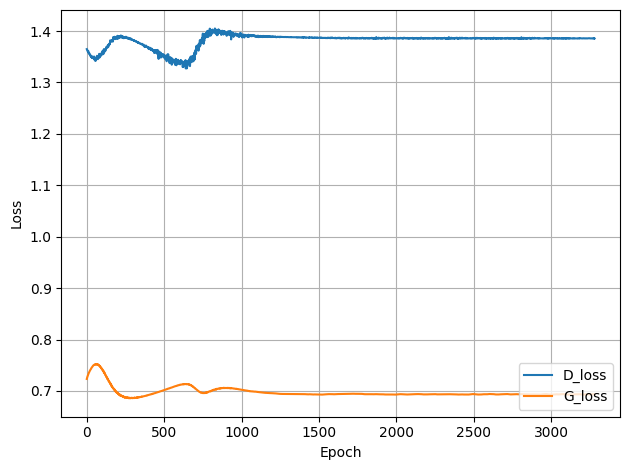

In [ ]:
key = train_GAN( 128 , 7)

In [ ]:
show_result(x_test, 10)

Streaming output truncated to the last 5000 lines.
Epoch 1, Batch 258, G Loss: 0.6871870160102844, D Loss: 1.386091709136963
Epoch 1, Batch 259, G Loss: 0.6869339942932129, D Loss: 1.3864376544952393
Epoch 1, Batch 260, G Loss: 0.6869618892669678, D Loss: 1.3861730098724365
Epoch 1, Batch 261, G Loss: 0.6874763369560242, D Loss: 1.385347843170166
Epoch 1, Batch 262, G Loss: 0.6872107982635498, D Loss: 1.3858940601348877
Epoch 1, Batch 263, G Loss: 0.6875807046890259, D Loss: 1.3856987953186035
Epoch 1, Batch 264, G Loss: 0.6869651675224304, D Loss: 1.3858742713928223
Epoch 1, Batch 265, G Loss: 0.6874104738235474, D Loss: 1.3853614330291748
Epoch 1, Batch 266, G Loss: 0.6872320175170898, D Loss: 1.3857641220092773
Epoch 1, Batch 267, G Loss: 0.6875940561294556, D Loss: 1.3850884437561035
Epoch 1, Batch 268, G Loss: 0.6874316334724426, D Loss: 1.3858890533447266
Epoch 1, Batch 269, G Loss: 0.6872687935829163, D Loss: 1.3862589597702026
Epoch 1, Batch 270, G Loss: 0.6872411966323853, D L

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 6, Batch 568, G Loss: 0.6936879754066467, D Loss: 1.3859058618545532
Epoch 6, Batch 569, G Loss: 0.6936749815940857, D Loss: 1.3864972591400146
Epoch 6, Batch 570, G Loss: 0.6936684250831604, D Loss: 1.3863790035247803
Epoch 6, Batch 571, G Loss: 0.6936642527580261, D Loss: 1.3865281343460083
Epoch 6, Batch 572, G Loss: 0.6936714053153992, D Loss: 1.385742425918579
Epoch 6, Batch 573, G Loss: 0.6936350464820862, D Loss: 1.3859248161315918
Epoch 6, Batch 574, G Loss: 0.6935725212097168, D Loss: 1.3856682777404785
Epoch 6, Batch 575, G Loss: 0.6934798955917358, D Loss: 1.3858301639556885
Epoch 6, Batch 576, G Loss: 0.6933658123016357, D Loss: 1.3862559795379639
Epoch 6, Batch 577, G Loss: 0.6932563185691833, D Loss: 1.3862390518188477
Epoch 6, Batch 578, G Loss: 0.6931647658348083, D Loss: 1.386519193649292
Epoch 6, Batch 579, G Loss: 0.693095326423645, D Loss: 1.386625051498413
Epoch 6, Batch 580, G Loss: 0.6930592656135559, D Loss: 1.385937213897705
Epoch 6, Batch 581, G Loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 6, Batch 591, G Loss: 0.6931222677230835, D Loss: 1.3861750364303589
Epoch 6, Batch 592, G Loss: 0.6932082176208496, D Loss: 1.386317253112793
Epoch 6, Batch 593, G Loss: 0.6932845115661621, D Loss: 1.3865094184875488
Epoch 6, Batch 594, G Loss: 0.6933764815330505, D Loss: 1.386574387550354
Epoch 6, Batch 595, G Loss: 0.6934688091278076, D Loss: 1.3868091106414795
Epoch 6, Batch 596, G Loss: 0.6935811042785645, D Loss: 1.3862721920013428
Epoch 6, Batch 597, G Loss: 0.6936848163604736, D Loss: 1.386265516281128
Epoch 6, Batch 598, G Loss: 0.6937784552574158, D Loss: 1.3863985538482666
Epoch 6, Batch 599, G Loss: 0.6938549876213074, D Loss: 1.3864753246307373
Epoch 6, Batch 600, G Loss: 0.6939411759376526, D Loss: 1.3865917921066284
Epoch 6, Batch 601, G Loss: 0.694038450717926, D Loss: 1.3865230083465576
Epoch 6, Batch 602, G Loss: 0.6941304206848145, D Loss: 1.3866153955459595
Epoch 6, Batch 603, G Loss: 0.6942331790924072, D Loss: 1.3864140510559082
Epoch 6, Batch 604, G Loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 6, Batch 640, G Loss: 0.6937702894210815, D Loss: 1.3860671520233154
Epoch 6, Batch 641, G Loss: 0.6937707662582397, D Loss: 1.3860793113708496
Epoch 6, Batch 642, G Loss: 0.6937719583511353, D Loss: 1.386102557182312
Epoch 6, Batch 643, G Loss: 0.6937882304191589, D Loss: 1.3860995769500732
Epoch 6, Batch 644, G Loss: 0.6937997937202454, D Loss: 1.3862370252609253
Epoch 6, Batch 645, G Loss: 0.6937988996505737, D Loss: 1.3860812187194824
Epoch 6, Batch 646, G Loss: 0.6937894821166992, D Loss: 1.3862738609313965
Epoch 6, Batch 647, G Loss: 0.6937816143035889, D Loss: 1.3862683773040771
Epoch 6, Batch 648, G Loss: 0.6937346458435059, D Loss: 1.3862526416778564
Epoch 6, Batch 649, G Loss: 0.6937130689620972, D Loss: 1.3860185146331787
Epoch 6, Batch 650, G Loss: 0.6936851739883423, D Loss: 1.386335849761963
Epoch 6, Batch 651, G Loss: 0.6936488151550293, D Loss: 1.3861733675003052
Epoch 6, Batch 652, G Loss: 0.6936156749725342, D Loss: 1.3857882022857666
Epoch 6, Batch 653, G Loss:

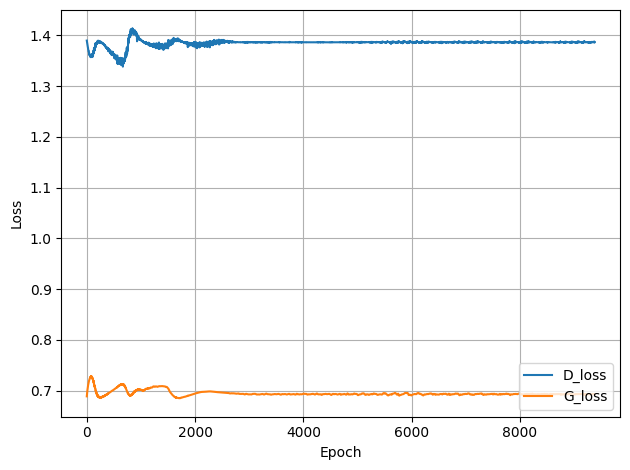

In [ ]:
# Set parameters
batch_size = 64
epochs = 10
latent = 100  # Update as per your latent dimension

# Train the GAN
train_GAN(batch_size, epochs)


In [ ]:
# Load and preprocess MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.expand_dims(x_train, axis=-1).astype('float32') / 255.0
x_test = np.expand_dims(x_test, axis=-1).astype('float32') / 255.0

# Test the model on the test dataset
def test_discriminator(discriminator):
    test_images_resized = tf.image.resize(x_test, (height, width)).numpy()
    predictions = discriminator.predict(test_images_resized)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = y_test
    accuracy = np.mean(predicted_labels == true_labels)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Train the GAN
# train_GAN(100, 7)

# Test the discriminator
test_discriminator(discriminator)

AttributeError: ignored

In [ ]:
############ Imports ############

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from PIL import Image
import time

############ Initializations ############

num_classes = 10
channels = 1
height = 64
width = 64
# MNIST was resized to 64 * 64 for discriminator and generator architecture fitting
latent = 100
epsilon = 1e-7
labeled_rate = 0.2 # For initial testing

############ Importing MNIST data ############

def get_data():
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

    # Expanding the dimensions to add a channel dimension and converting to float
    train_images = np.expand_dims(train_images, axis=-1).astype('float32')
    test_images = np.expand_dims(test_images, axis=-1).astype('float32')

    # Converting labels to one-hot encoded format
    train_labels = tf.keras.utils.to_categorical(train_labels, 10)
    test_labels = tf.keras.utils.to_categorical(test_labels, 10)

    return train_images, train_labels, test_images, test_labels


                ############ Normalizing data ############
# Scaling in range (-1,1) for generator tanh output
def scale(x):
    # normalize data
    x = (x - 0.5) / 0.5
    return x

"""Discriminator and Generator architecture should mirror each other"""

############ Defining Discriminator ############

def discriminator(x, dropout_rate = 0., is_training = True, reuse = False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        print('Discriminator architecture: ')

        # Layer 1
        conv1 = tf.keras.layers.Conv2D(filters=128, kernel_size=[4,4], strides=[2,2], padding='same', activation=tf.nn.leaky_relu, name='conv1')(x)
        dropout1 = tf.nn.dropout(conv1, dropout_rate)
        print(conv1.shape)

        # Layer 2
        conv2 = tf.keras.layers.Conv2D(filters=256, kernel_size=[4,4], strides=[2,2], padding='same', activation=tf.nn.leaky_relu, name='conv2')(dropout1)
        batch2 = tf.keras.layers.BatchNormalization()(conv2, training=is_training)
        dropout2 = tf.nn.dropout(batch2, dropout_rate)
        print(conv2.shape)

        # Layer 3
        conv3 = tf.keras.layers.Conv2D(filters=512, kernel_size=[4,4], strides=[4,4], padding='same', activation=tf.nn.leaky_relu, name='conv3')(dropout2)
        batch3 = tf.keras.layers.BatchNormalization()(conv3, training=is_training)
        dropout3 = tf.nn.dropout(batch3, dropout_rate)
        print(conv3.shape)

        # Layer 4
        conv4 = tf.keras.layers.Conv2D(filters=1024, kernel_size=[3,3], strides=[1,1], padding='valid', activation=tf.nn.leaky_relu, name='conv4')(dropout3)
        print(conv4.shape)

        # Flatten and Dense Layer
        flatten = tf.reduce_mean(conv4, axis=[1, 2])
        logits_D = tf.keras.layers.Dense(1 + num_classes)(flatten)

        out_D = tf.nn.softmax(logits_D)

    return flatten, logits_D, out_D


############ Defining Generator ############

def generator(z, dropout_rate = 0., is_training = True, reuse = False):
    # input latent z -> image x

    with tf.variable_scope('Generator', reuse = reuse):
      print('\n Generator architecture: ')

      #Layer 1
      deconv1 = tf.layers.conv2d_transpose(z, 512, kernel_size = [4,4],
                                         strides = [1,1], padding = 'valid',
                                        activation = tf.nn.relu, name = 'deconv1') # ?*4*4*512
      batch1 = tf.layers.batch_normalization(deconv1, training = is_training)
      dropout1 = tf.nn.dropout(batch1, dropout_rate)
      print(deconv1.shape)

      #Layer 2
      deconv2 = tf.layers.conv2d_transpose(dropout1, 256, kernel_size = [4,4],
                                         strides = [4,4], padding = 'same',
                                        activation = tf.nn.relu, name = 'deconv2')# ?*16*16*256
      batch2 = tf.layers.batch_normalization(deconv2, training = is_training)
      dropout2 = tf.nn.dropout(batch2, dropout_rate)
      print(deconv2.shape)

      #Layer 3
      deconv3 = tf.layers.conv2d_transpose(dropout2, 128, kernel_size = [4,4],
                                         strides = [2,2], padding = 'same',
                                        activation = tf.nn.relu, name = 'deconv3')# ?*32*32*256
      batch3 = tf.layers.batch_normalization(deconv3, training = is_training)
      dropout3 = tf.nn.dropout(batch3, dropout_rate)
      print(deconv3.shape)

      #Output layer
      deconv4 = tf.layers.conv2d_transpose(dropout3, 1, kernel_size = [4,4],
                                        strides = [2,2], padding = 'same',
                                        activation = None, name = 'deconv4')# ?*64*64*1
      out = tf.nn.tanh(deconv4)
      print(deconv4.shape)

    return out

############ Building model ############

def build_GAN(x_real, z, dropout_rate, is_training):

    fake_images = generator(z, dropout_rate, is_training)

    D_real_features, D_real_logits, D_real_prob = discriminator(x_real, dropout_rate,
                                                              is_training)

    D_fake_features, D_fake_logits, D_fake_prob = discriminator(fake_images, dropout_rate,
                                                                is_training, reuse = True)
    #Setting reuse=True this time for using variables trained in real batch training

    return D_real_features, D_real_logits, D_real_prob, D_fake_features, D_fake_logits, D_fake_prob, fake_images

############ Preparing Mask ############

# Preparing a binary label_mask to be multiplied with real labels
def get_labeled_mask(labeled_rate, batch_size):
    labeled_mask = np.zeros([batch_size], dtype=np.float32)
    labeled_count = int(batch_size * labeled_rate)
    labeled_mask[range(labeled_count)] = 1.0
    np.random.shuffle(labeled_mask)
    return labeled_mask

############ Preparing Extended label ############

def prepare_extended_label(label):
    # add extra label for fake data
    extended_label = tf.concat([tf.zeros([tf.shape(label)[0], 1]), label], axis = 1)

    return extended_label

############ Defining losses ############

# The total loss inculcates  D_L_Unsupervised + D_L_Supervised + G_feature_matching loss + G_R/F loss

def loss_accuracy(D_real_features, D_real_logit, D_real_prob, D_fake_features,
                  D_fake_logit, D_fake_prob, extended_label, labeled_mask):

                    ### Discriminator loss ###

    # Supervised loss -> which class the real data belongs to

    temp = tf.nn.softmax_cross_entropy_with_logits_v2(logits = D_real_logit,
                                                  labels = extended_label)
    # Don't confuse labeled_rate with labeled_mask
    # Labeled_mask and temp are of same size = batch_size where temp is softmax
    # cross_entropy calculated over whole batch

    D_L_Supervised = tf.reduce_sum(tf.multiply(temp,labeled_mask)) / tf.reduce_sum(labeled_mask)

    # Multiplying temp with labeled_mask gives supervised loss on labeled_mask
    # data only, calculating mean by dividing by no of labeled samples

    # Unsupervised loss -> R/F

    D_L_RealUnsupervised = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits = D_real_logit[:, 0], labels = tf.zeros_like(D_real_logit[:, 0], dtype=tf.float32)))

    D_L_FakeUnsupervised = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits = D_fake_logit[:, 0], labels = tf.ones_like(D_fake_logit[:, 0], dtype=tf.float32)))

    D_L = D_L_Supervised + D_L_RealUnsupervised + D_L_FakeUnsupervised


                    ### Generator loss ###

    # G_L_1 -> Fake data wanna be real

    G_L_1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits = D_fake_logit[:, 0],labels = tf.zeros_like(D_fake_logit[:, 0], dtype=tf.float32)))

    # G_L_2 -> Feature matching
    data_moments = tf.reduce_mean(D_real_features, axis = 0)
    sample_moments = tf.reduce_mean(D_fake_features, axis = 0)
    G_L_2 = tf.reduce_mean(tf.square(data_moments-sample_moments))


    G_L = G_L_1 + G_L_2

    prediction = tf.equal(tf.argmax(D_real_prob[:, 1:], 1),
                                  tf.argmax(extended_label[:, 1:], 1))
    accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))

    return D_L, G_L, accuracy

############ Defining Optimizer ############

def optimizer(D_Loss, G_Loss, learning_rate, beta1):
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        all_vars = tf.trainable_variables()
        D_vars = [var for var in all_vars if var.name.startswith('Discriminator')]
        G_vars = [var for var in all_vars if var.name.startswith('Generator')]

        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1,
                                             name = 'd_optimiser').minimize(D_Loss, var_list=D_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1,
                                             name = 'g_optimiser').minimize(G_Loss, var_list=G_vars)

    return d_train_opt, g_train_opt

############ Plotting Results ############

def show_result(test_images, num_epoch, show = True, save = False, path = 'result.png'):

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i in range(0, size_figure_grid):
      for j in range(0, size_figure_grid):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(size_figure_grid*size_figure_grid):
        i = k // size_figure_grid
        j = k % size_figure_grid
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k], (64, 64)), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):


    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

############ TRAINING ############

def train_GAN(batch_size, epochs):

    train_hist = {}
    train_hist['D_losses'] = []
    train_hist['G_losses'] = []

    tf.reset_default_graph()

    x = tf.placeholder(tf.float32, shape=[None, height, width, channels], name='x')
    z = tf.placeholder(tf.float32, shape=[None, 1, 1, latent], name='z')
    label = tf.placeholder(tf.float32, shape=[None, num_classes], name='label')
    labeled_mask = tf.placeholder(tf.float32, shape=[None], name='labeled_mask')
    dropout_rate = tf.placeholder(tf.float32, name='dropout_rate')
    is_training = tf.placeholder(tf.bool, name='is_training')

    lr_rate = 2e-4

    model = build_GAN(x, z, dropout_rate, is_training)
    D_real_features, D_real_logit, D_real_prob, D_fake_features, D_fake_logit, D_fake_prob, fake_data = model

    extended_label = prepare_extended_label(label)

    # Fake_data of size = batch_size*28*28*1

    loss_acc = loss_accuracy(D_real_features, D_real_logit, D_real_prob,
                                  D_fake_features, D_fake_logit, D_fake_prob,
                                  extended_label, labeled_mask)
    D_L, G_L, accuracy = loss_acc

    D_optimizer, G_optimizer = optimizer(D_L, G_L, lr_rate, beta1 = 0.5)

    print ('...Training begins...')

    with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())

      train_images, train_labels, test_images, test_labels = get_data()
      no_of_batches = int(train_images.shape[0] / batch_size)

      for epoch in range(epochs):

        train_accuracies, train_D_losses, train_G_losses = [], [], []
            # Shuffle dataset at the beginning of each epoch
        indices = np.arange(train_images.shape[0])
        np.random.shuffle(indices)
        shuffled_train_images = train_images[indices]
        shuffled_train_labels = train_labels[indices]
        for it in range(no_of_batches):

          start = it * batch_size
          end = min(start + batch_size, train_images.shape[0])
          batch_images = shuffled_train_images[start:end]
          batch_labels = shuffled_train_labels[start:end]

          # Resize images
          batch_images_resized = np.array([np.array(Image.fromarray(img.squeeze(), 'L').resize((64, 64))) for img in batch_images])
          batch_images_resized = np.expand_dims(batch_images_resized, axis=-1)

          # Normalize images
          batch_images_normalized = scale(batch_images_resized)

          # Generate random noise for generator
          batch_z = np.random.normal(0, 1, (batch_images_resized.shape[0], 1, 1, latent))

          # Create mask for labeled data
          mask = get_labeled_mask(labeled_rate, batch_images_resized.shape[0])

          # Create feed dictionary
          train_feed_dict = {
              x: batch_images_normalized,
              z: batch_z,
              label: batch_labels,
              labeled_mask: mask,
              dropout_rate: 0.7,
              is_training: True
          }
          #The label provided in dict are one hot encoded in 10 classes

          D_optimizer.run(feed_dict = train_feed_dict)
          G_optimizer.run(feed_dict = train_feed_dict)

          train_D_loss = D_L.eval(feed_dict = train_feed_dict)
          train_G_loss = G_L.eval(feed_dict = train_feed_dict)
          train_accuracy = accuracy.eval(feed_dict = train_feed_dict)

          train_D_losses.append(train_D_loss)
          train_G_losses.append(train_G_loss)
          train_accuracies.append(train_accuracy)
          print('Batch evaluated: ' +str(it+1))

        tr_GL = np.mean(train_G_losses)
        tr_DL = np.mean(train_D_losses)
        tr_acc = np.mean(train_accuracies)

        print ('After epoch: '+ str(epoch+1) + ' Generator loss: '
                       + str(tr_GL) + ' Discriminator loss: ' + str(tr_DL) + ' Accuracy: ' + str(tr_acc))

        gen_samples = fake_data.eval(feed_dict = {z : np.random.normal(0, 1, (25, 1, 1, latent)), dropout_rate : 0.7, is_training : False})
        # Dont train batch-norm while plotting => is_training = False
        test_images = tf.image.resize_images(gen_samples, [64, 64]).eval()
        show_result(test_images, (epoch + 1), show = True, save = False, path = '')

        train_hist['D_losses'].append(np.mean(train_D_losses))
        train_hist['G_losses'].append(np.mean(train_G_losses))

      show_train_hist(train_hist, show=True, save = True, path = 'train_hist.png')
      sess.close()

    return train_D_losses,train_G_losses

key = train_GAN( 128 , 7)

Instructions for updating:
non-resource variables are not supported in the long term
<ipython-input-1-890cf22b52bd>:92: UserWarning: `tf.layers.conv2d_transpose` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2DTranspose` instead.
  deconv1 = tf.layers.conv2d_transpose(z, 512, kernel_size = [4,4],
<ipython-input-1-890cf22b52bd>:95: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  batch1 = tf.layers.batch_normalization(deconv1, training = is_training)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
<ipython-input-1-890cf22b52bd>:100: UserWarning: `tf.laye


 Generator architecture: 
(?, 4, 4, 512)


<ipython-input-1-890cf22b52bd>:103: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  batch2 = tf.layers.batch_normalization(deconv2, training = is_training)
<ipython-input-1-890cf22b52bd>:108: UserWarning: `tf.layers.conv2d_transpose` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2DTranspose` instead.
  deconv3 = tf.layers.conv2d_transpose(dropout2, 128, kernel_size = [4,4],
<ipython-input-1-890cf22b52bd>:111: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormali

(?, 16, 16, 256)
(?, 32, 32, 128)
(?, 64, 64, 1)
Discriminator architecture: 
(?, 32, 32, 128)
(?, 16, 16, 256)
(?, 4, 4, 512)
(?, 2, 2, 1024)
Discriminator architecture: 
(?, 32, 32, 128)
(?, 16, 16, 256)
(?, 4, 4, 512)
(?, 2, 2, 1024)
...Training begins...
Batch evaluated: 1
Batch evaluated: 2
Batch evaluated: 3
Batch evaluated: 4
Batch evaluated: 5
Batch evaluated: 6
Batch evaluated: 7
Batch evaluated: 8


KeyboardInterrupt: ignored

To measure the performance of our GAN model on the test set, we will need to evaluate the discriminator's ability to classify real images from the test set accurately. Since GANs are typically used for generation tasks, their performance is often assessed qualitatively through the visual inspection of generated images. However, for the discriminator in a GAN, we can quantify its performance using classification accuracy on real images.

In [ ]:
def preprocess_test_data(test_images):
    # Resize images
    test_images_resized = np.array([np.array(Image.fromarray(img.squeeze(), 'L').resize((64, 64))) for img in test_images])
    test_images_resized = np.expand_dims(test_images_resized, axis=-1)

    # Normalize images
    test_images_normalized = scale(test_images_resized)
    return test_images_normalized

def evaluate_discriminator(sess, x, dropout_rate, is_training, D_real_logits, test_images, test_labels):
    test_images_preprocessed = preprocess_test_data(test_images)

    real_prediction = tf.nn.sigmoid(D_real_logits[:, 0])  # Assuming first logit is for real/fake classification
    predictions = sess.run(real_prediction, feed_dict={x: test_images_preprocessed, dropout_rate: 0.0, is_training: False})
    predicted_labels = (predictions > 0.5).astype(np.int32)
    true_labels = (np.argmax(test_labels, axis=1) == 0).astype(np.int32)  # Assuming real images are labeled as class 0

    accuracy = np.mean(predicted_labels == true_labels)
    return accuracy
